# Necessary Packages

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset and Preprocessing

In [ ]:
def load_data_df(data_dir, img_size=(32,32)):
    class_names = sorted(os.listdir(data_dir))
    rows = []
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        rows.extend({'filepath': os.path.join(class_path, f),
                     'label': label,
                     'class_name': class_name} for f in files)

    df = pd.DataFrame(rows).sample(frac=1, random_state=42).reset_index(drop=True)

    X = np.zeros((len(df), img_size[0] * img_size[1]), dtype=np.uint8)
    y = df['label'].values

    for i, fp in enumerate(df['filepath']):
        try:
            img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            X[i, :] = img.flatten()
        except:
            pass
    return X, y, class_names, df

train_folder = "/content/drive/MyDrive/animal_dataset/train"
test_folder = "/content/drive/MyDrive/animal_dataset/test"

X_train, y_train, class_names, df_train = load_data_df(train_folder)
X_test, y_test, _, df_test = load_data_df(test_folder)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(df_train.head())

Train shape: (210, 1024), Test shape: (90, 1024)
                                            filepath  label class_name
0  /content/drive/MyDrive/animal_dataset/train/ca...      0        cat
1  /content/drive/MyDrive/animal_dataset/train/pa...      2      panda
2  /content/drive/MyDrive/animal_dataset/train/do...      1        dog
3  /content/drive/MyDrive/animal_dataset/train/pa...      2      panda
4  /content/drive/MyDrive/animal_dataset/train/ca...      0        cat


# k-Nearest Neighbors (k-NN) Algorithm

In [ ]:
class KNN:
    def __init__(self, k=3, metric='l2'):
        self.k = k
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        y_pred = np.zeros(X_test.shape[0], dtype=int)
        for i, xi in enumerate(X_test):
            diff = self.X_train.astype(float) - xi.astype(float)
            if self.metric == 'l1':
                distances = np.sum(np.abs(diff), axis=1)
            else:
                distances = np.sqrt(np.sum(diff**2, axis=1))
            k_idx = np.argsort(distances)[:self.k]
            k_labels = self.y_train[k_idx]
            y_pred[i] = np.argmax(np.bincount(k_labels, minlength=len(class_names)))
        return y_pred

# 5-Fold Cross-Validation

In [ ]:
def cross_validate(X, y, k_values, num_folds=5, metric='l2'):
    fold_size = len(X) // num_folds
    all_accuracies = []

    for k in k_values:
        fold_acc = []
        for fold in range(num_folds):
            start = fold * fold_size
            end = (fold + 1) * fold_size
            X_val = X[start:end]
            y_val = y[start:end]
            X_tr = np.concatenate([X[:start], X[end:]])
            y_tr = np.concatenate([y[:start], y[end:]])

            knn = KNN(k=k, metric=metric)
            knn.fit(X_tr, y_tr)
            preds = knn.predict(X_val)
            fold_acc.append(np.mean(preds == y_val))
        all_accuracies.append(fold_acc)
        print(f"K={k}, {metric.upper()} Mean Acc={np.mean(fold_acc):.3f}")
    return all_accuracies

k_values = [1, 3, 5, 7]
print("Euclidean (L2) Cross-Validation:")
l2_acc = cross_validate(X_train, y_train, k_values, metric='l2')
print("Manhattan (L1) Cross-Validation:")
l1_acc = cross_validate(X_train, y_train, k_values, metric='l1')

Euclidean (L2) Cross-Validation:
K=1, L2 Mean Acc=0.343
K=3, L2 Mean Acc=0.371
K=5, L2 Mean Acc=0.357
K=7, L2 Mean Acc=0.386
Manhattan (L1) Cross-Validation:
K=1, L1 Mean Acc=0.405
K=3, L1 Mean Acc=0.400
K=5, L1 Mean Acc=0.371
K=7, L1 Mean Acc=0.414


# Results and Analysis

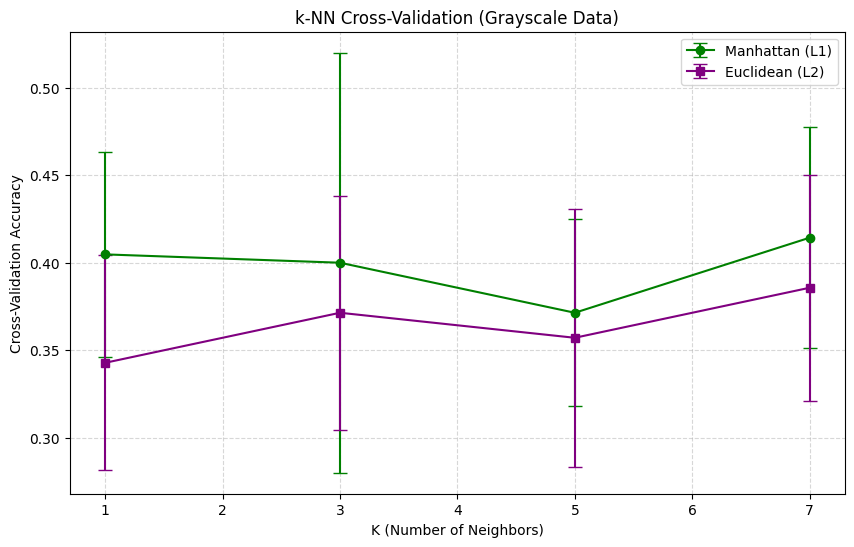

In [ ]:
l2_means = [np.mean(a) for a in l2_acc]
l2_stds = [np.std(a) for a in l2_acc]
l1_means = [np.mean(a) for a in l1_acc]
l1_stds = [np.std(a) for a in l1_acc]

plt.figure(figsize=(10,6))
plt.errorbar(k_values, l1_means, yerr=l1_stds, fmt='-o', label='Manhattan (L1)', color='green', capsize=5)
plt.errorbar(k_values, l2_means, yerr=l2_stds, fmt='-s', label='Euclidean (L2)', color='purple', capsize=5)
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("k-NN Cross-Validation (Grayscale Data)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Top 5 Predictions

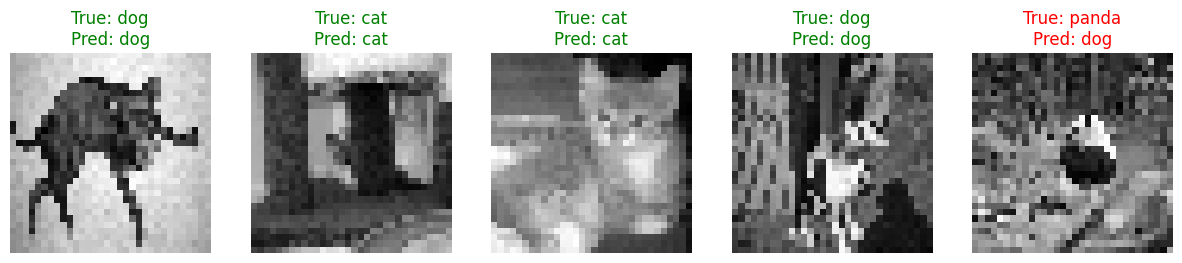

In [ ]:
best_k = k_values[np.argmax(l2_means)]
knn_best = KNN(k=best_k, metric='l2')
knn_best.fit(X_train, y_train)

if len(X_test) >= 5:
    indices = np.random.choice(len(X_test), 5, replace=False)
    X_sample = X_test[indices]
    y_sample = y_test[indices]

    preds = knn_best.predict(X_sample)

    plt.figure(figsize=(15,3))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(X_sample[i].reshape(32,32), cmap='gray')
        color = 'green' if preds[i] == y_sample[i] else 'red'
        plt.title(f"True: {class_names[y_sample[i]]}\nPred: {class_names[preds[i]]}", color=color)
        plt.axis('off')
    plt.show()